In [16]:
import pandas as pd
import numpy as np
import time
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as rng
import re
from scipy.stats import qmc
from mpl_toolkits.mplot3d import Axes3D
from itertools import product, combinations
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

caminho_do_projeto = r'C:\Users\kmenezes\OneDrive - unb.br\tcc_organizacao'

if caminho_do_projeto not in sys.path:
    sys.path.insert(0, caminho_do_projeto)
from projeto_aplicado.modelos.otimizador_pli import OtimizadorPLI
from projeto_aplicado.modelos.otimizador_aco import OtimizadorACO
from projeto_aplicado.modelos.otimizador_ag import OtimizadorAG
from projeto_aplicado.modelos.otimizador_base import Otimizador
from projeto_aplicado.modelos.analisador import AnalisadorDeSolucao
base = r"C:\\Users\\kmenezes\\OneDrive - unb.br\\tcc_organizacao\\dados"
grafs_dir = r"C:\\Users\\kmenezes\\OneDrive - unb.br\\tcc_organizacao\\graficos"

# Configurações de visualização
sns.set_theme(style="whitegrid")
pd.set_option('display.max_rows', 100)

cor1 = "#006064"
cor2 = "#D35400"
cores = ['#006064', '#D35400', '#2E86C1', '#884EA0', '#28B463', '#7F8C8D']
gradiente = LinearSegmentedColormap.from_list("meu_gradiente", ["#E0F7FA", "#006064"])

In [78]:
df = pd.read_csv('dados_robustez.csv')

df['tempo_conv_aco'] = df['geracao_convergencia_aco'] * (df['tempo_aco'] / 150)
df['tempo_conv_ag'] = df['geracao_convergencia_ag'] * (df['tempo_ag'] / 350)

In [79]:
d1 = df['metricas_preferencia'].apply(eval).apply(pd.Series)
d2 = df['metricas_horario'].apply(eval).apply(pd.Series)
d3 = df['resultado_pli'].apply(eval).str[0].apply(pd.Series)[['escore_total']].rename(columns={'escore_total':'escore_pli'})
d4 = df['resultado_aco'].apply(eval).str[0].apply(pd.Series)[['escore_total']].rename(columns={'escore_total':'escore_aco'})
d5 = df['resultado_ag'].apply(eval).str[0].apply(pd.Series)[['escore_total']].rename(columns={'escore_total':'escore_ag'})

df = pd.concat([df[['simulacao', 'folga_total', 'tempo_pli', 'tempo_aco', 'tempo_ag', 'tempo_conv_aco', 'tempo_conv_ag']]
                , d1, d2, d3, d4, d5], axis=1)

df['escore_aco'] = (df['escore_aco']/df['escore_pli']).apply(lambda x: min(x, 1.0))
df['escore_ag'] = (df['escore_ag']/df['escore_pli']).apply(lambda x: min(x, 1.0))
df['escore_pli'] = 1.0

df_long1 = pd.melt(df, id_vars=['simulacao'], value_vars=['escore_pli', 'escore_aco', 'escore_ag'],
                  var_name='metodo', value_name='pontuacao_relativa')
df_long1['metodo'] = df_long1['metodo'].str.replace('escore_', '')

df_long2 = pd.melt(df, id_vars=['simulacao'], value_vars=['tempo_pli', 'tempo_aco', 'tempo_ag'],
                  var_name='metodo', value_name='tempo_total')
df_long2['metodo'] = df_long2['metodo'].str.replace('tempo_', '')

df_long3 = pd.melt(df, id_vars=['simulacao'], value_vars=['tempo_conv_aco', 'tempo_conv_ag'],
                    var_name='metodo', value_name='tempo_convergencia')
df_long3['metodo'] = df_long3['metodo'].str.replace('tempo_conv_', '')

df_long = pd.merge(df_long1, df_long2, on=['simulacao', 'metodo']).merge(df_long3, on=['simulacao', 'metodo'], how='left')

df_long = df_long.merge(df[['simulacao', 'folga_total', 'proporcao_perturbacao', 'n_interessados_por_turma', 'n_mudancas_horarios', 'n_conflitos']], on='simulacao')
df_long['tempo_convergencia'] = df_long['tempo_convergencia'].fillna(df_long['tempo_total'])

C:\Users\kmenezes\AppData\Local\Temp\ipykernel_7164\4055618142.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\kmenezes\AppData\Local\Temp\ipykernel_7164\4055618142.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


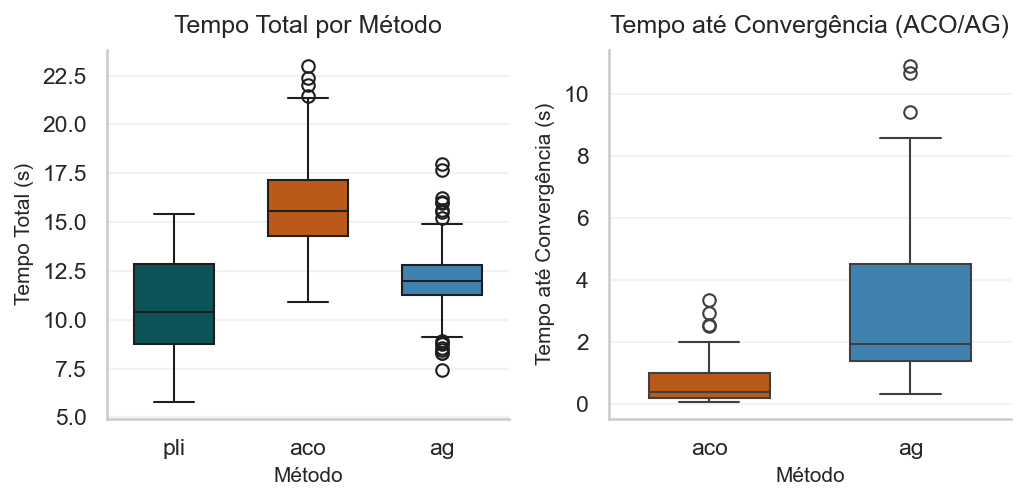

In [80]:
# ...existing code...
# === Grid 1x2: Boxplots (Tempo Total e Tempo até Convergência) ===
# Usa df_long e o estilo/paleta do projeto
pal_metodo = {"pli": cor1, "aco": cor2, "ag": cores[2]}

# Prepara dados do tempo total
df_bt = df_long.copy()
df_bt["metodo"] = df_bt["metodo"].astype(str)

# Prepara dados de tempo até convergência (apenas ACO e AG, PLI não tem)
df_conv = df_long[df_long["metodo"].isin(["aco", "ag"])].copy()

fig, axes = plt.subplots(1, 2, figsize=(7, 3.5), dpi=150)

# Boxplot Tempo Total
sns.boxplot(
    data=df_bt,
    x="metodo",
    y="tempo_total",
    order=["pli", "aco", "ag"],
    palette=[pal_metodo["pli"], pal_metodo["aco"], pal_metodo["ag"]],
    width=0.6,
    ax=axes[0]
)
axes[0].set_title("Tempo Total por Método", fontsize=12, pad=8)
axes[0].set_xlabel("Método", fontsize=10)
axes[0].set_ylabel("Tempo Total (s)", fontsize=10)
axes[0].grid(True, axis="y", alpha=0.25)
for spine in ["top", "right"]:
    axes[0].spines[spine].set_visible(False)

# Boxplot Tempo até Convergência (ACO/AG)
sns.boxplot(
    data=df_conv,
    x="metodo",
    y="tempo_convergencia",
    order=["aco", "ag"],
    palette=[pal_metodo["aco"], pal_metodo["ag"]],
    width=0.6,
    ax=axes[1]
)
axes[1].set_title("Tempo até Convergência (ACO/AG)", fontsize=12, pad=8)
axes[1].set_xlabel("Método", fontsize=10)
axes[1].set_ylabel("Tempo até Convergência (s)", fontsize=10)
axes[1].grid(True, axis="y", alpha=0.25)
for spine in ["top", "right"]:
    axes[1].spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(grafs_dir, "grid_boxplots_tempo_total_e_convergencia.pdf"), dpi=300, bbox_inches="tight")
plt.show()
# ...existing code...

C:\Users\kmenezes\AppData\Local\Temp\ipykernel_12356\954572189.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


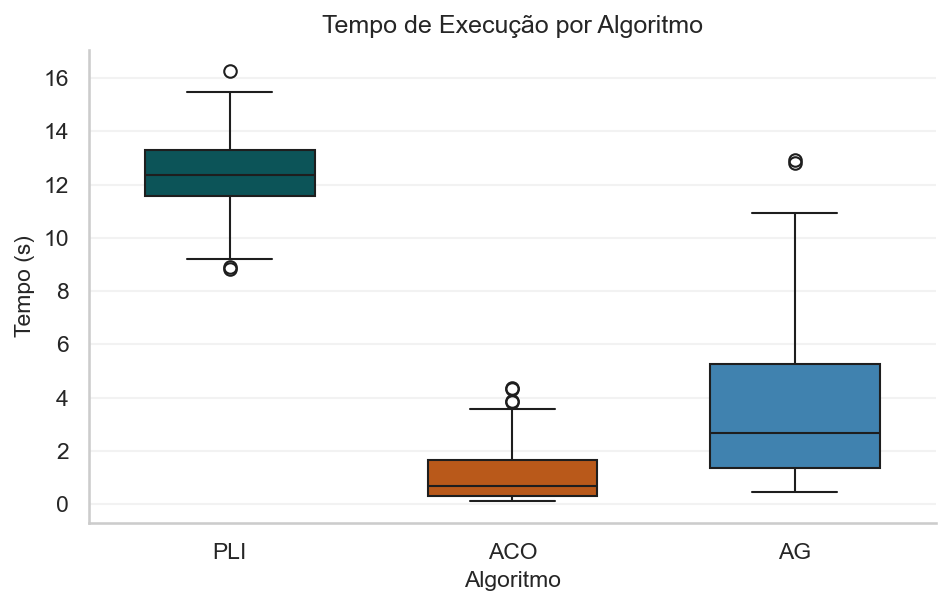

In [22]:
# ...existing code...
# === Boxplot: comparação do tempo de execução (PLI, ACO, AG) ===
# Mantém o estilo das outras análises (whitegrid, cores cor1/cor2 e paleta coerente)
tempo_cols = ["tempo_pli", "tempo_aco", "tempo_ag"]
df_box = df[tempo_cols].copy()

# Converte para formato longo
df_a1 = df_box.melt(var_name="algoritmo", value_name="tempo").copy()

# Mapeia nomes amigáveis
alg_labels = {"tempo_pli": "PLI", "tempo_aco": "ACO", "tempo_ag": "AG"}
df_a1["algoritmo"] = df_a1["algoritmo"].map(alg_labels)

plt.figure(figsize=(6.5, 4.2), dpi=150)
sns.boxplot(
    data=df_a1,
    x="algoritmo",
    y="tempo",
    palette=[cores[0], cores[1], cores[2]],  # reutiliza paleta do projeto
    width=0.6
)

plt.title("Tempo de Execução por Algoritmo", fontsize=12, pad=8)
plt.xlabel("Algoritmo", fontsize=11)
plt.ylabel("Tempo (s)", fontsize=11)
plt.grid(True, axis="y", alpha=0.25)
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
#plt.savefig(os.path.join(grafs_dir, "boxplot_tempo_execucao_algoritmos.pdf"), dpi=300, bbox_inches="tight")
plt.show()


In [70]:
df_long.head()

,simulacao,metodo,pontuacao_relativa,tempo_total,tempo_convergencia,folga_total,proporcao_perturbacao,n_interessados_por_turma,n_mudancas_horarios,n_conflitos
0,1.0,pli,1.0,5.781250,NaN,4,0.498630,3.348869,25.0,130.0
1,2.0,pli,1.0,7.390625,NaN,4,0.497153,6.945779,25.0,130.0
2,3.0,pli,1.0,10.390625,NaN,0,0.251018,3.744952,17.0,152.0
3,4.0,pli,1.0,7.281250,NaN,2,0.000000,2.102165,8.0,177.0
4,5.0,pli,1.0,10.546875,NaN,2,0.161926,3.418939,14.0,163.0


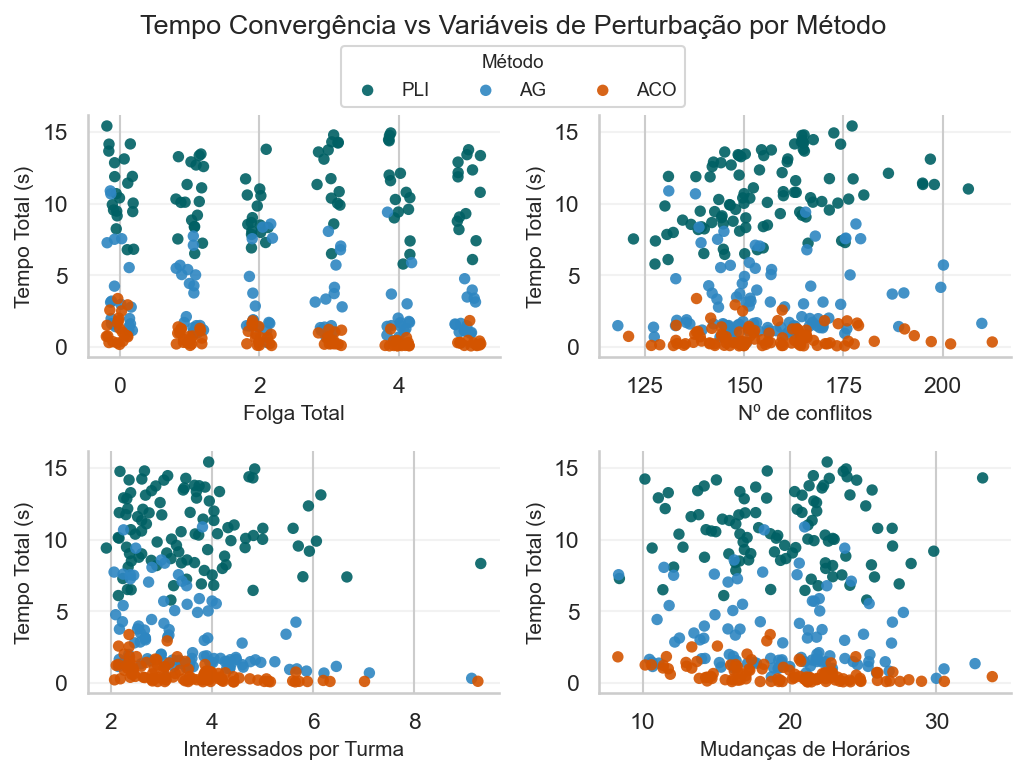

In [81]:
# ...existing code...
# === Grid 2x2: Scatter (Y = tempo_total) colorido por método ===
scatter_grid_cfg = {
    "size": 30,
    "alpha": 0.90,
    "edgecolor": "none",
    "edgewidth": 0.35,
    "jitter_x_factor": 0.04,
    "seed": 321,
    "save": True
}
rng_g = np.random.default_rng(scatter_grid_cfg["seed"])

pal_metodo = {"pli": cor1, "ag": cores[2], "aco": cor2}
x_vars = ["folga_total", "n_conflitos", "n_interessados_por_turma", "n_mudancas_horarios"]

# Nomes customizáveis para eixo X (edite conforme necessidade)
x_labels = {
    "folga_total": "Folga Total",
    "n_conflitos": "Nº de conflitos",
    "n_interessados_por_turma": "Interessados por Turma",
    "n_mudancas_horarios": "Mudanças de Horários"
}

# Tamanho otimizado para relatório A4 (paisagem)
fig, axes = plt.subplots(2, 2, figsize=(7, 5), dpi=150)
axes = axes.flatten()

order_plot = ["pli", "ag", "aco"]  # ordem solicitada

for ax, xcol in zip(axes, x_vars):
    x_vals = df_long[xcol].astype(float).to_numpy()
    y_vals = df_long["tempo_convergencia"].astype(float).to_numpy()
    metodo = df_long["metodo"].to_numpy()

    x_range = max(1e-12, x_vals.max() - x_vals.min())
    x_jitter = rng_g.uniform(-scatter_grid_cfg["jitter_x_factor"] * x_range,
                             scatter_grid_cfg["jitter_x_factor"] * x_range,
                             size=len(x_vals))
    x_plot = x_vals + x_jitter

    for m in order_plot:
        if m not in df_long["metodo"].unique():
            continue
        mask = (metodo == m)
        ax.scatter(
            x_plot[mask],
            y_vals[mask],
            s=scatter_grid_cfg["size"],
            alpha=scatter_grid_cfg["alpha"],
            facecolor=pal_metodo.get(m, "#666"),
            edgecolor=scatter_grid_cfg["edgecolor"],
            linewidth=scatter_grid_cfg["edgewidth"],
            label=m.upper() if xcol == x_vars[0] else None
        )

    ax.set_xlabel(x_labels.get(xcol, xcol.replace("_", " ").title()), fontsize=10)
    ax.set_ylabel("Tempo Total (s)", fontsize=10)
    ax.grid(True, axis="y", alpha=0.25)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

handles, labels = axes[0].get_legend_handles_labels()

# Legenda posicionada logo abaixo do título, centralizada
fig.suptitle("Tempo Convergência vs Variáveis de Perturbação por Método", fontsize=13, y=1.03)
fig.legend(
    handles, labels,
    loc="upper center",
    ncol=3, frameon=True,
    fontsize=9, title="Método", title_fontsize=9,
    bbox_to_anchor=(0.5, 1)  # ajusta para ficar abaixo do título
)
plt.tight_layout()

if scatter_grid_cfg["save"]:
    plt.savefig(os.path.join(grafs_dir, "grid_scatter_tempo_total_vs_variaveis_por_metodo.pdf"),
                dpi=300, bbox_inches="tight")
plt.show()
# ...existing code...

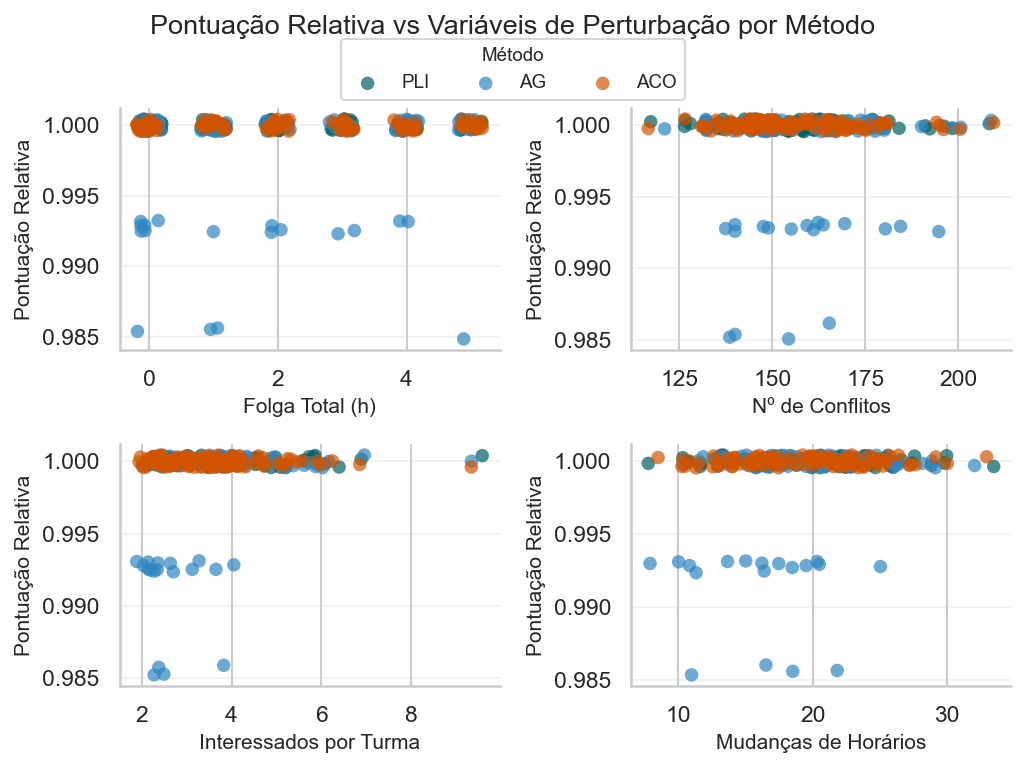

In [82]:
# ...existing code...
# === Grid 2x2: Scatter (Y = pontuacao_relativa) colorido por método, com jitter em X e Y ===
scatter_grid_cfg = {
    "size": 42,
    "alpha": 0.70,
    "edgecolor": "none",
    "edgewidth": 0.35,
    "jitter_x_factor": 0.04,
    "jitter_y_factor": 0.03,   # jitter no eixo Y
    "seed": 321,
    "save": True,
}
rng_g = np.random.default_rng(scatter_grid_cfg["seed"])

pal_metodo = {"pli": cor1, "ag": cores[2], "aco": cor2}
x_vars = ["folga_total", "n_conflitos", "n_interessados_por_turma", "n_mudancas_horarios"]

# Labels customizáveis para eixo X
x_labels = {
    "folga_total": "Folga Total (h)",
    "n_conflitos": "Nº de Conflitos",
    "n_interessados_por_turma": "Interessados por Turma",
    "n_mudancas_horarios": "Mudanças de Horários"
}

fig, axes = plt.subplots(2, 2, figsize=(7, 5), dpi=150)  # tamanho A4 paisagem
axes = axes.flatten()

order_plot = ["pli", "ag", "aco"]  # ordem solicitada

for ax, xcol in zip(axes, x_vars):
    x_vals = df_long[xcol].astype(float).to_numpy()
    y_vals_base = df_long["pontuacao_relativa"].astype(float).to_numpy()
    metodo = df_long["metodo"].to_numpy()

    # jitter X
    x_range = max(1e-12, x_vals.max() - x_vals.min())
    x_jitter = rng_g.uniform(-scatter_grid_cfg["jitter_x_factor"] * x_range,
                             scatter_grid_cfg["jitter_x_factor"] * x_range,
                             size=len(x_vals))
    x_plot = x_vals + x_jitter

    # jitter Y (usa amplitude dos dados)
    y_range = max(1e-12, y_vals_base.max() - y_vals_base.min())
    y_jitter = rng_g.uniform(-scatter_grid_cfg["jitter_y_factor"] * y_range,
                             scatter_grid_cfg["jitter_y_factor"] * y_range,
                             size=len(y_vals_base))
    y_plot = y_vals_base + y_jitter

    for m in order_plot:
        if m not in df_long["metodo"].unique():
            continue
        mask = (metodo == m)
        ax.scatter(
            x_plot[mask],
            y_plot[mask],
            s=scatter_grid_cfg["size"],
            alpha=scatter_grid_cfg["alpha"],
            facecolor=pal_metodo.get(m, "#666"),
            edgecolor=scatter_grid_cfg["edgecolor"],
            linewidth=scatter_grid_cfg["edgewidth"],
            label=m.upper() if xcol == x_vars[0] else None
        )

    ax.set_xlabel(x_labels.get(xcol, xcol.replace("_", " ").title()), fontsize=10)
    ax.set_ylabel("Pontuação Relativa", fontsize=10)
    ax.grid(True, axis="y", alpha=0.25)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle("Pontuação Relativa vs Variáveis de Perturbação por Método", fontsize=13, y=1.02)
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=True,
           fontsize=9, title="Método", title_fontsize=9, bbox_to_anchor=(0.5, 1))

plt.tight_layout()

if scatter_grid_cfg["save"]:
    plt.savefig(os.path.join(grafs_dir, "grid_scatter_pontuacao_relativa_vs_variaveis_por_metodo.pdf"),
                dpi=300, bbox_inches="tight")
plt.show()
# ...existing code...

In [62]:
df_long

,simulacao,metodo,pontuacao_relativa,tempo_total,folga_total,proporcao_perturbacao,n_interessados_por_turma,n_mudancas_horarios
0,1.0,pli,1.000000,9.546875,5,0.246191,3.788957,10.0
1,2.0,pli,1.000000,9.562500,0,0.062492,2.393467,9.0
2,3.0,pli,1.000000,10.000000,2,0.260977,2.804301,10.0
3,4.0,pli,1.000000,8.437500,2,0.104551,2.634891,9.0
4,5.0,pli,1.000000,9.968750,3,0.139710,2.706801,10.0
...,...,...,...,...,...,...,...,...
295,96.0,ag,1.000000,2.877857,4,0.106286,2.544900,9.0
296,97.0,ag,0.992537,5.810804,2,0.000000,2.102165,9.0
297,98.0,ag,1.000000,1.799241,2,0.142635,2.244923,10.0
298,99.0,ag,0.978261,5.312500,1,0.087188,2.294035,9.0
